# horsing around with the backprop algorithm
Marcus started this see how quickly he could get backprop to stand up.

Note the use of "checkgrad", which exhaustively confirms that the gradient calculation is in fact correct - not something to run all the time but a useful check to have.

Issues:
  * the neural net has no biases yet
  * the learning problem is just random - better if we could read in a training set

In [1]:
import numpy as np
import numpy.random as rng
import sklearn
import sklearn.datasets as ds
import sklearn.cross_validation as cv
import sklearn.neighbors as nb
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision = 2, suppress = True)

### specify a neuron transfer function ('f'), and its derivative ('df')

In [2]:
# THESE FUNCTIONS MUST MATCH ONE ANOTHER................

def f( phi ):  
    # phi is always going to be a weighted sum (probably a matrix of).
    x = 1.0/ (1.0 + np.exp(-phi))
    
    #ALT: rectified linear goes like this
    #x = phi * (phi>0.0)
    return x

def df( x ):  # MUST MATCH WHAT YOU PUT HERE with the f function.
    # This is the gradient of the transfer function
    # with respect to "phi", the weighted sum of inputs to the neuron.
    # HOWEVER NOTE that unlike f(), the input argument isn't phi here - it's the function value itself.

    dx = x*(1-x)
    #ALT: rectified linear goes like this
    #dx = 1.0*(x>0.0)
    return dx

### get or make some training data
Got to have something to work on.

In [3]:
# I'm going to be dumb here and make them from my very own random perceptrons!
# However you do it, call the input patterns "inpats" (each row is a pattern), and the output patterns "targets".
Nins, Nouts, Npats = 8, 2, 100
inputX = rng.normal(0,1,size=(Npats,Nins))
tmpNhids = 10
tmp_weights = rng.normal(0,1,size=(Nins,tmpNhids))
hidphi = np.dot(inputX, tmp_weights)
tmp_weights = rng.normal(0,1,size=(tmpNhids,Nouts))
phi = np.dot(f(hidphi), tmp_weights)
Targ = 1.0* (f(phi) > 0.5)
print (inputX[:3, :])
print (Targ[:3, :])

[[-0.31 -1.42  0.23  0.65 -1.27  1.37 -0.19 -0.13]
 [ 0.49 -1.68 -0.52  0.79 -2.6   1.46  0.03  0.94]
 [-0.    0.23 -0.05  0.69  0.44 -0.02  0.08 -0.51]]
[[ 1.  0.]
 [ 1.  0.]
 [ 0.  0.]]


In [4]:
# It would be better to use some realistic data actually.
# But this is a classification dataset, so we'll need more than 1 transfer function 
# (one for the hidden layers, but a softmax for the output). So I won't cloud the issue here.........

#digits = ds.load_digits()
#X = digits.data
#Targ = digits.target  # currently a vector - but we want a nx1 matrix,so...
#Targ = np.reshape(Targ, (len(Targ), 1))  
#print(X.shape, Targ.shape)
#print(X.min(), X.max())

### The function we're climbing

In [5]:
def calc_goodness(Y, Targ):  # often this is called the "Loss" or the "Cost function" (and given a minus sign accordingly).
    # outputs is a matrix (Npats, Nouts), and targets is what we'd like those to be.
    error = Targ - Y
    Good_vec = -0.5*np.power(error,2.0) # inverted parabola centered on the target outputs
    dGood_vec = error # e.g. if output is too low, this should be positive.
    return Good_vec.sum(), Good_vec, dGood_vec

### set the network's architecture

In [6]:
Npats = inputX.shape[0]
architecture = [inputX.shape[1], 5, 3, Targ.shape[1]]
#architecture = [inpats.shape[1], targets.shape[1]]
print ('There are this many neurons in each layer: ', architecture)  # a list of the number of neurons in each layer

There are this many neurons in each layer:  [8, 5, 3, 2]


In [7]:
X = [inputX] 
# X is going to be a list giving the activations of successive layers. 
# Each one is a matrix, whose columns are the neurons in that layer.
# Each row in the matrix corresponds to a training item.
# So all the matrices in the list X will have the same number of rows.

for L in range(1, len(architecture)):
    X.append(np.zeros(shape=(Npats, architecture[L]), dtype=float))

for L in range(len(architecture)): 
    print('layer %d activations have shape ' %(L), X[L].shape)

layer 0 activations have shape  (100, 8)
layer 1 activations have shape  (100, 5)
layer 2 activations have shape  (100, 3)
layer 3 activations have shape  (100, 2)


### set up the weights

In [8]:
# Then we have the weights. I'm going to index weight layer by the layer they're *going* towards.
# So I'll have a zeroth weight layer for sanity, but it's going to be empty!
# NOTE: no implementation of bias weights here, yet!
W  = [np.array(None)]
dW = [np.array(None)]
for L in range(1,len(X)):
    init_weights_scale = 0.1  #1/np.sqrt((X[L].shape()).max())

    Nins = X[L-1].shape[1]
    Nouts = X[L].shape[1]
    W.append(init_weights_scale * rng.normal(0,1,size=(Nouts, Nins)) )
    dW.append(0.0 * np.copy(W[L]))

for L in range(len(W)):
    print('layer %d weights have shape ' %(L), W[L].shape)

layer 0 weights have shape  ()
layer 1 weights have shape  (5, 8)
layer 2 weights have shape  (3, 5)
layer 3 weights have shape  (2, 3)


### forward pass

In [9]:
def forward_pass(X, W):
    for L in range(1,len(X)):
        x = X[L-1].transpose()
        # print (L, W[L].shape, x.shape)
        X[L] = f(np.dot(W[L], x).transpose())
    return X

### backward pass

In [10]:
def backward_pass(X, W, dW, targets):
    good_sum, good_vec, dgood = calc_goodness(X[-1], targets)
    epsilon = dgood
    npats = X[0].shape[0]
    for L in range(len(X)-1,0,-1):
        psi = epsilon * df(X[L]) # elt-wise multiply
        n1, n2 = X[L-1].shape[1], psi.shape[1]
        A = np.tile(X[L-1],n2).reshape(npats,n2,n1)
        B = np.repeat(psi,n1).reshape(npats,n2,n1)        
        dW[L] = (A*B).sum(0) # outer product multiply
        epsilon = np.dot(psi, W[L]) # inner product multiply
    return dW

In [11]:
X = forward_pass(X, W)
dW = backward_pass(X, W, dW, Targ)

In [12]:
def checkgrad(dW, X, W, targets):
    # Check the gradient directly, via perturbations to every weight.
    # This is completely daft in practical terms, but very useful for debugging.
    # ie. it tells you whether your backprop of errors really is returning the true gradient.
    tiny = 0.0001
    
    dW_test = [np.array(None)]
    for L in range(1,len(W)):
        dW_test.append(0.0*np.copy(W[L]))
    
    X = forward_pass(X,W)
    base_good, tmp1, tmp2 = calc_goodness(X[-1], targets)
    
    for L in range(1,len(X)):
        for j in range(W[L].shape[0]): # index of destination node
            for i in range(W[L].shape[1]): # index of origin node
                # perturb that weight
                (W[L])[j,i] = (W[L])[j,i] + tiny
                # compute and store the empirical gradient estimate
                X = forward_pass(X,W)
                tmp_good, tmp1, tmp2 = calc_goodness(X[-1], targets)
                (dW_test[L])[j,i] = (tmp_good - base_good)/tiny                
                # unperturb the weight
                (W[L])[j,i] = (W[L])[j,i] - tiny
                
    # show the result?
    for L in range(1,len(X)):
        print ('-------------- layer %d --------------' %(L))
        print ('calculated gradients:')
        print (dW[L])
        print ('empirical gradients:')
        print (dW_test[L])

In [13]:
checkgrad(dW, X, W, Targ)

-------------- layer 1 --------------
calculated gradients:
[[ 0.    0.   -0.   -0.    0.   -0.   -0.   -0.  ]
 [-0.    0.    0.    0.    0.   -0.    0.   -0.  ]
 [ 0.    0.   -0.   -0.    0.    0.   -0.   -0.  ]
 [ 0.   -0.01  0.    0.   -0.01  0.    0.    0.  ]
 [-0.   -0.    0.    0.   -0.    0.    0.    0.  ]]
empirical gradients:
[[ 0.    0.   -0.   -0.    0.   -0.   -0.   -0.  ]
 [-0.    0.    0.    0.    0.   -0.    0.   -0.  ]
 [ 0.    0.   -0.   -0.    0.    0.   -0.   -0.  ]
 [ 0.   -0.01  0.    0.   -0.01  0.    0.    0.  ]
 [-0.   -0.    0.    0.   -0.    0.    0.    0.  ]]
-------------- layer 2 --------------
calculated gradients:
[[-0.24 -0.24 -0.24 -0.23 -0.24]
 [ 0.06  0.06  0.06  0.06  0.06]
 [ 0.13  0.12  0.13  0.13  0.12]]
empirical gradients:
[[-0.24 -0.24 -0.24 -0.23 -0.24]
 [ 0.06  0.06  0.06  0.06  0.06]
 [ 0.13  0.12  0.13  0.13  0.12]]
-------------- layer 3 --------------
calculated gradients:
[[ 2.27  2.33  2.3 ]
 [-6.09 -6.26 -6.17]]
empirical gradients:
[[

## yay.
The gradient seems to be right for the full MLP, so that's... progress!

Let's try learning the problem then....

In [14]:
def learn(X, W, dW, targets, learning_rate=0.01, momentum=0.1, num_steps=1):
    # note dW and prev_change are of the same size as W - we'll make space for them first
    times, vals = [], []
    next_time = 0
    
    prev_change = [np.array(None)]
    for L in range(1,len(X)):
        prev_change.append(0.0 * np.copy(W[L]))
    
    # now for the learning iterations
    for step in range(num_steps):
        X = forward_pass(X,W)
        
        # this is just record-keeping.......
        if step == next_time:
            good_sum, good_vec, dgood = calc_goodness(X[-1], targets)
            vals.append(good_sum)
            times.append(step)
            next_time = step + 10

        dW = backward_pass(X, W, dW, targets)
        for L in range(1,len(X)):
            change =  (learning_rate * dW[L])  +  (momentum * prev_change[L])
            W[L] = W[L] + change
            prev_change[L] = change


    return W, times, vals

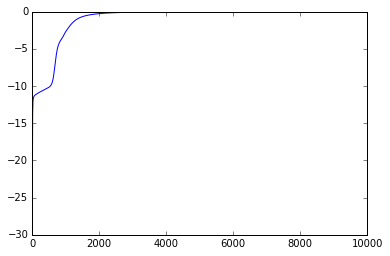

In [15]:
W, vals, times = learn(X, W, dW, Targ, learning_rate=0.01, momentum=0.5, num_steps=10000)
plt.plot(vals, times)